##Load necesary dasets

In [82]:
import os
import random
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


##Loading Datsets

In [59]:
TRAIN_DIR = '/content/drive/MyDrive/Colab Notebooks/Dataset/animal_dataset'
CATEGORIES = []
for c in os.listdir(TRAIN_DIR):
    CATEGORIES.append(c)
print(CATEGORIES)

['dog', 'panda', 'cat']


In [60]:
TRAIN_DATA = []
IMG_SIZE = 32
for c in CATEGORIES:
    path = os.path.join(TRAIN_DIR,c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        img_arr = cv2.imread(os.path.join(path,img))
        img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
        TRAIN_DATA.append([img_arr, class_num])
print(len(TRAIN_DATA))
print(img_arr.shape)

100%|██████████| 100/100 [00:00<00:00, 103.79it/s]

300
(32, 32, 3)


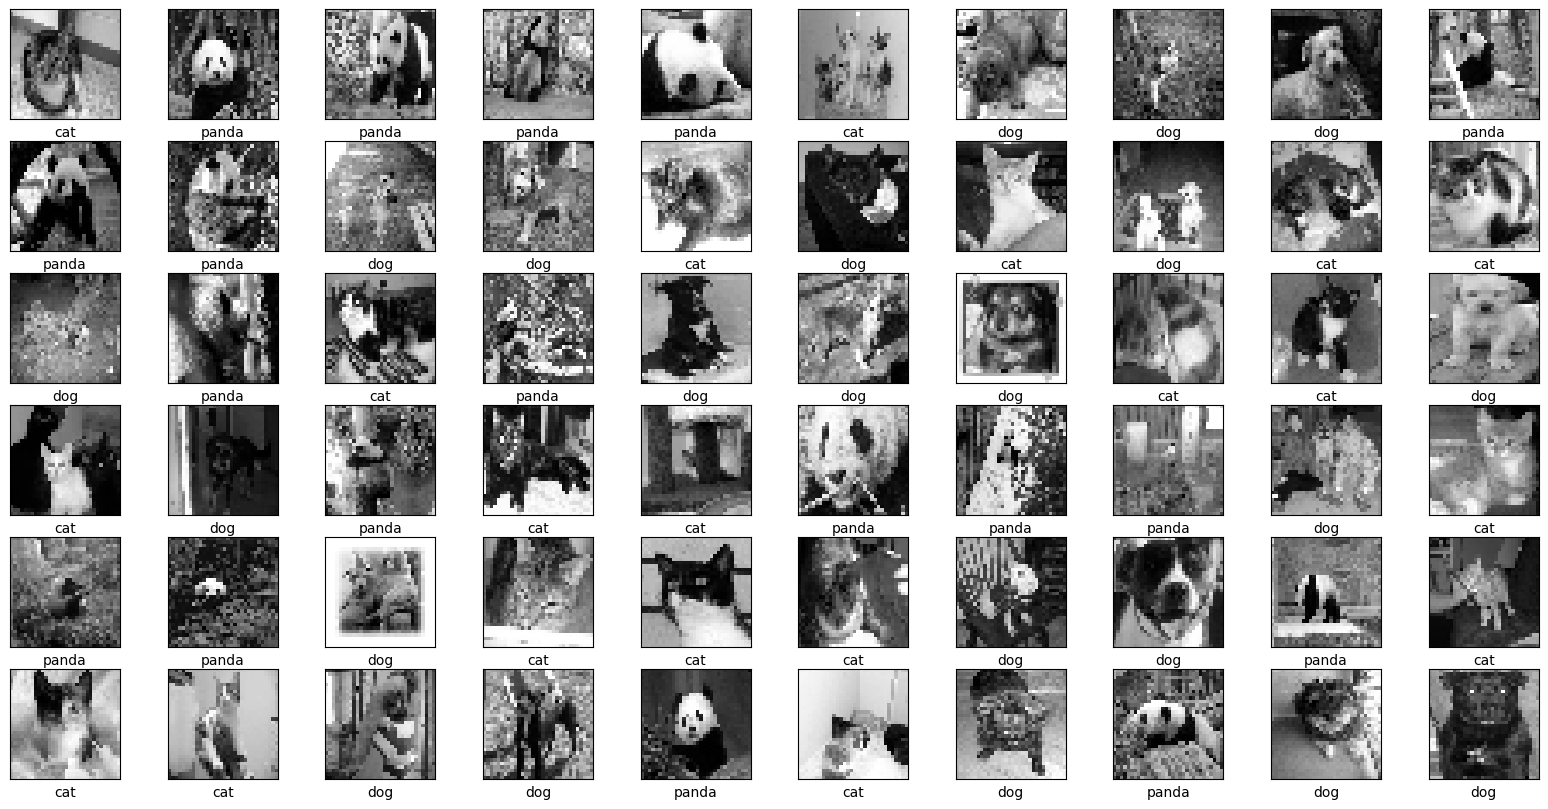

In [61]:
random.shuffle(TRAIN_DATA)
plt.figure(figsize=(20,10))
for i in range(60):
    plt.subplot(6,10,i+1)
    image = TRAIN_DATA[i][0]
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i==60:
        break
plt.show()

In [62]:
fold_size = len(TRAIN_DATA) // 5
fold0 = TRAIN_DATA[0:fold_size]
fold1 = TRAIN_DATA[fold_size:fold_size*2]
fold2 = TRAIN_DATA[fold_size*2:fold_size*3]
fold3 = TRAIN_DATA[fold_size*3:fold_size*4]
fold4 = TRAIN_DATA[fold_size*4:fold_size*5]

In [63]:
def l1_dist(image1, image2):
    return np.sum(np.abs(image1 - image2))

def l2_dist(image1, image2):
    return np.sqrt(np.sum((image1 - image2) ** 2))

In [64]:
def by_l1_dist(list):
    return list[2]["l1"]

def by_l2_dist(list):
    return list[2]["l2"]

In [65]:
top_filter = 20

def distance_calc(train_fold, valid_fold):
    l1_result = []
    l2_result = []

    for valid in tqdm(valid_fold):
        temp_dist_list = []

        for train in train_fold:
            l1_distance = l1_dist(valid[0], train[0])
            l2_distance = l2_dist(valid[0], train[0])
            temp_dist_list.append([valid[1],  train[1], {"l1": l1_distance, "l2": l2_distance}])

        temp_dist_list.sort(key=by_l1_dist)
        l1_result.append(temp_dist_list[:top_filter])
        temp_dist_list.sort(key=by_l2_dist)
        l2_result.append(temp_dist_list[:top_filter])

    return [l1_result, l2_result]

In [66]:
k_range = 20

def cal_accuracy(dist_result, dist_term):
    k_accuracies = []

    for k in range(1, k_range+1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]
            same_class = [n for n in nn if n[0] == n[1]]
            same_class_len = len(same_class)

            if k % 2 != 0:
                if ((k-1) / 2) < same_class_len:
                    img_accuracy += 1

            else:
                diff_class = [n for n in nn if n[0] != n[1]]
                if same_class_len > len(diff_class):
                    img_accuracy += 1
                elif same_class_len == len(diff_class): # in case of a tie
                    same_class_dist = sum([n[2][dist_term] for n in same_class])
                    diff_class_dist = sum([n[2][dist_term] for n in diff_class])
                    if same_class_dist > diff_class_dist:
                        img_accuracy += 1

        k_accuracies.append(img_accuracy/len(dist_result))

    return k_accuracies

##Training

In [67]:
dist_by_fold = []
import math
for i in range(5):
    if i==0:
        train = fold1+fold2+fold3+fold4
        validation = fold0
    elif i==1:
        train = fold0+fold2+fold3+fold4
        validation = fold1
    elif i==2:
        train = fold1+fold0+fold3+fold4
        validation = fold2
    elif i==3:
        train = fold1+fold2+fold0+fold4
        validation = fold3
    elif i==4:
        train = fold1+fold2+fold3+fold0
        validation = fold4

    dist_by_fold.append(distance_calc(train, validation))

100%|██████████| 60/60 [00:00<00:00, 157.35it/s]


In [68]:
len(dist_by_fold[0][0])

60

In [69]:
accuracies = []

for result in dist_by_fold:
    if result[0]:
        l1_accuracy = cal_accuracy(result[0], "l1")
    else:
        l1_accuracy = [0.0] * k_range

    if result[1]:
        l2_accuracy = cal_accuracy(result[1], "l2")
    else:
        l2_accuracy = [0.0] * k_range

    accuracies.append([l1_accuracy, l2_accuracy])

In [70]:
len(accuracies)

5

##Result and analysis

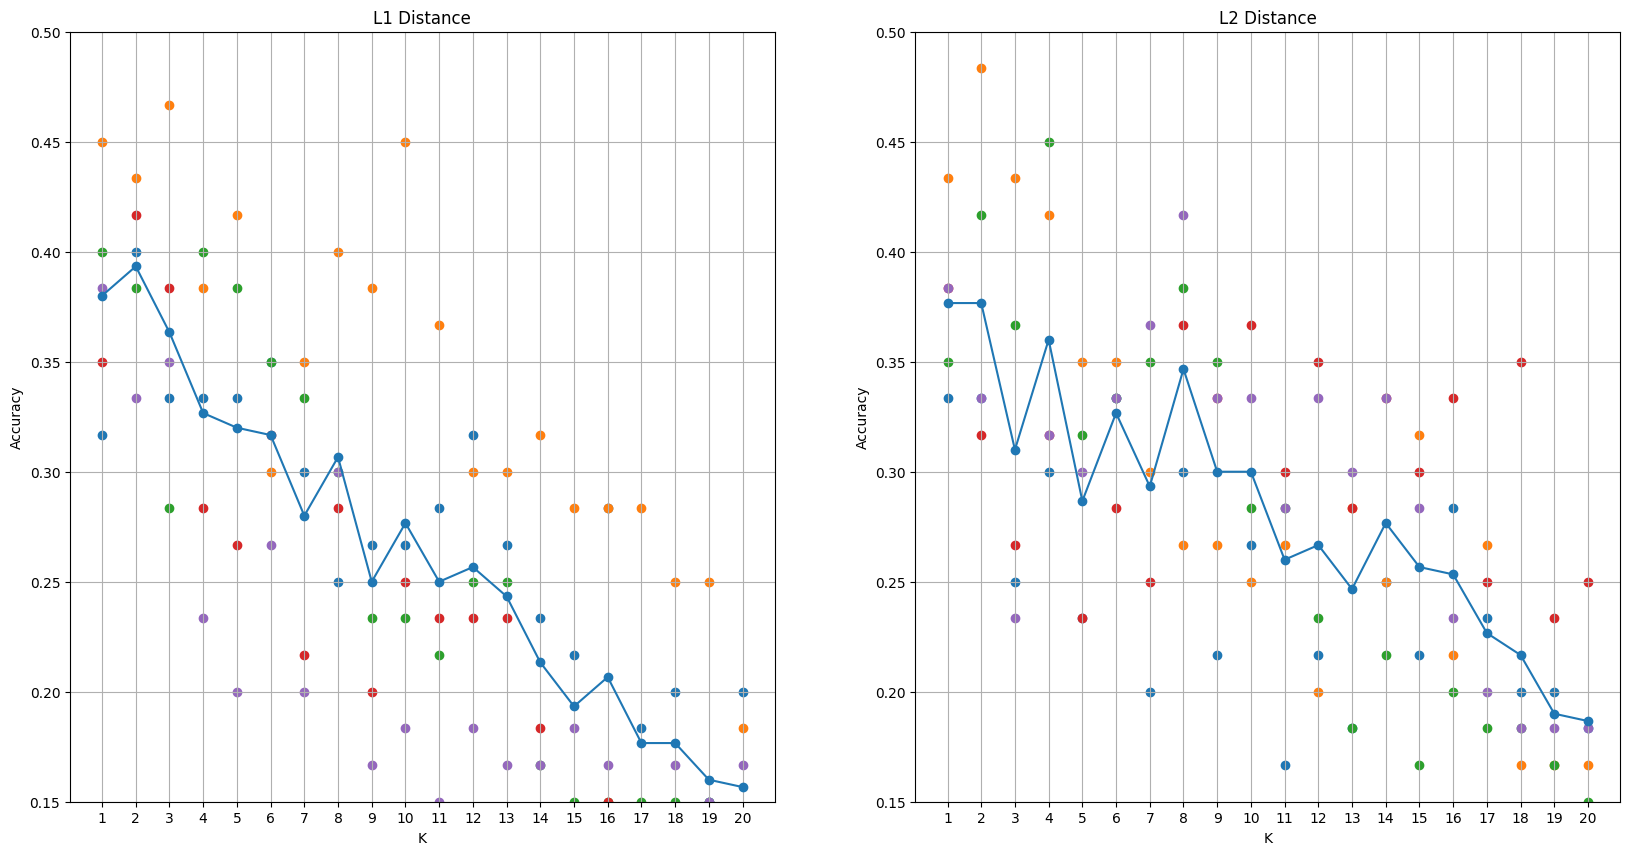

In [71]:
x_list = list(range(1, k_range+1))

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)

for fold in accuracies:
  y_list = fold[0]
  plt.scatter(x_list, y_list)

arr = []
for i in range(k_range):
  arr.append([fold[0][i] for fold in accuracies])

trend = [np.mean(a) for a in arr]

plt.errorbar(x_list, trend,fmt='-o')
plt.title('L1 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.ylim(0.15, 0.5)

x_list = list(range(1, k_range+1))

plt.subplot(1,2,2)
for fold in accuracies:
  y_list = fold[1]
  plt.scatter(x_list, y_list)

arr = []
for i in range(k_range):
  arr.append([fold[1][i] for fold in accuracies])

trend = [np.mean(a) for a in arr]

plt.errorbar(x_list, trend,fmt='-o')
plt.title('L2 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.ylim(0.15, 0.5)
plt.show()

Top 5 Predictions

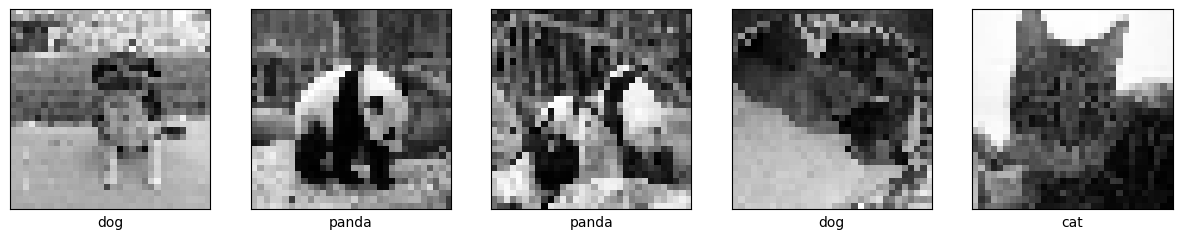

In [75]:
random.shuffle(TRAIN_DATA)
test_images = []

plt.figure(figsize=(15, 10))

for i in range(5):
    plt.subplot(3, 5, i+1)
    image = TRAIN_DATA[i][0]
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    test_images.append([image_gray, CATEGORIES[TRAIN_DATA[i][1]]])
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i == 5:
        break

## Discussion
1. According to the average accuracy values that were obtained on the 5-fold cross-validation, the Manhattan (L1) and Euclidean (L2) distance measures exhibit similar overriding trends with both attaining their optimal accuracy at lower values of k. Nevertheless, L1 distance seems slightly more stable with the change of k values whereas L2 varies more yet acquires similar peak performance. This implies that in this gray-scale data over which pixel differences may be susceptible to noise variations, the L1 measure might be more effective at preserving local structure by lessening the impact of coarse huge distinctions in intensity.

2. KNN performance is also sensitive to the complexity of the classes and high dimensionality of the gray-scale data, so the choice of distance should be considered. Although both metrics have a decent performance, the findings suggest that L1 can be slightly more appropriate to use in this task.

3. The weaknesses are that KNN is sensitive to scaling of features, noise and high dimensionality. The possible solutions are using dimensionality reduction, feature normalization or considering weighted KNN to provide closer neighbors with more weight, as it may increase the overall accuracy of the classification process.

